# **Dataset**

source : https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/



Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data is stored in a text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)	unit number

2)	time, in cycles

3)	operational setting 1

4)	operational setting 2

5)	operational setting 3

6)	sensor measurement  1

7)	sensor measurement  2

...

26)	sensor measurement  26

### **Aim** : To predict the Remaining Useful Life (RUL) of a turbofan engine

In [81]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgbm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense , LSTM, Dropout
from tensorflow.keras.models import Sequential, load_model
from pylab import rcParams
from tqdm import tqdm

%matplotlib inline

In [149]:
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/NASA_turbofan/train_FD001.txt', header = None, sep = ' ')
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/NASA_turbofan/test_FD001.txt', header = None, sep = ' ')

In [150]:
train_df.shape, test_df.shape

((20631, 28), (13096, 28))

In [151]:
train_df.isna().sum()/train_df.shape[0]*100

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26    100.0
27    100.0
dtype: float64

In [152]:
# Dropping lasto two columns as they are all NULL
train_df.drop(columns = [26,27], axis = 1, inplace = True)
test_df.drop(columns = [26,27], axis = 1, inplace = True)

In [153]:
train_df.shape, test_df.shape

((20631, 26), (13096, 26))

In [154]:
index_cols = ['Unit_no', 'time(cycles)']
op_setting_cols = ['op_setting_' + str(i) for i in range(1,4)]
sensor_cols = ['sensor_' + str(i) for i in range(1,22)]
cols = index_cols + op_setting_cols + sensor_cols
len(cols)

26

In [155]:
train_df.columns = cols
test_df.columns = cols

In [156]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unit_no       20631 non-null  int64  
 1   time(cycles)  20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

In [157]:
quants = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, .99]
train_df.describe(percentiles=quants).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Unit_no,20631.0,51.506568,2.922763e+01,1.0000,2.0000,10.0000,26.0000,52.0000,77.0000,92.0000,99.00000,100.0000
time(cycles),20631.0,108.807862,6.888099e+01,1.0000,3.0000,21.0000,52.0000,104.0000,156.0000,199.0000,288.00000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0051,-0.0028,-0.0015,0.0000,0.0015,0.0028,0.00500,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0005,-0.0004,-0.0002,0.0000,0.0003,0.0004,0.00050,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.00000,100.0000
sensor_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700,518.6700,518.6700,518.67000,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,641.6500,642.0600,642.3250,642.6400,643.0000,643.3600,643.93000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1577.6130,1583.0000,1586.2600,1590.1000,1594.3800,1598.8100,1605.87100,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1391.8830,1397.9800,1402.3600,1408.0400,1414.5550,1421.6500,1431.51700,1441.4900
sensor_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200,14.6200,14.6200,14.62000,14.6200


In [158]:
# Dropping the columns with zero variance
for col in sensor_cols:
  if train_df[col].var() <= 1e-5:
    train_df.drop(columns = col, axis = 1, inplace = True)
    test_df.drop(columns = col, axis = 1, inplace = True)

In [161]:
train_df.columns

Index(['Unit_no', 'time(cycles)', 'op_setting_1', 'op_setting_2',
       'op_setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7',
       'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21'],
      dtype='object')

In [162]:
# Computing the remaining useful life for the training data

max_life = train_df.groupby('Unit_no')['time(cycles)'].max().reset_index()
max_life.columns = ['Unit_no', 'max_life']
train_df = train_df.merge(max_life, left_on = 'Unit_no', right_on = 'Unit_no',how = 'inner').rename(columns = {'max_life_y' : 'max_life'})
train_df['RUL'] = train_df['max_life'] - train_df['time(cycles)']

In [163]:
train_df = train_df.drop(columns = ['max_life'], axis = 1)
train_df.sample(10)

,Unit_no,time(cycles),op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
18771,92,257,-0.0004,-0.0004,100.0,642.49,1591.75,1413.94,553.22,2388.08,9090.55,47.45,521.14,2388.09,8153.84,8.4692,394,38.75,23.3371,84
13803,69,173,-0.0021,0.0001,100.0,641.98,1580.64,1413.89,553.70,2388.05,9059.73,47.55,521.71,2388.03,8131.62,8.4332,392,38.70,23.3350,189
1937,10,24,-0.0047,-0.0004,100.0,642.00,1583.85,1393.75,554.92,2388.06,9062.47,47.33,522.84,2387.99,8140.26,8.3758,391,39.11,23.4183,198
15797,79,44,0.0044,0.0003,100.0,642.15,1581.65,1396.25,553.97,2387.97,9059.18,47.20,522.43,2387.98,8141.44,8.3778,392,39.21,23.5022,155
18005,88,210,0.0041,0.0001,100.0,643.92,1601.20,1426.06,551.87,2388.13,9143.49,48.14,520.02,2388.15,8210.67,8.5122,396,38.57,23.0343,3
16816,83,225,-0.0005,-0.0000,100.0,642.69,1593.81,1410.19,553.61,2388.07,9055.00,47.56,521.39,2388.06,8129.86,8.4185,394,38.78,23.2881,68
18754,92,240,0.0013,-0.0004,100.0,642.66,1586.19,1407.24,554.07,2388.09,9074.20,47.59,521.83,2388.07,8156.67,8.4466,394,38.78,23.2025,101
1357,7,54,0.0007,-0.0004,100.0,641.80,1590.77,1400.98,553.78,2387.99,9073.05,47.41,522.21,2387.98,8150.80,8.4129,392,39.01,23.4177,205
2189,11,54,-0.0006,-0.0005,100.0,642.36,1589.87,1394.84,554.59,2388.03,9054.95,47.23,522.00,2387.99,8142.01,8.4052,391,39.02,23.4614,186
16300,81,163,-0.0008,0.0003,100.0,643.04,1588.63,1413.74,553.72,2388.11,9056.48,47.73,521.41,2388.16,8138.41,8.4444,394,38.65,23.1557,77


## **Univariate analysis**

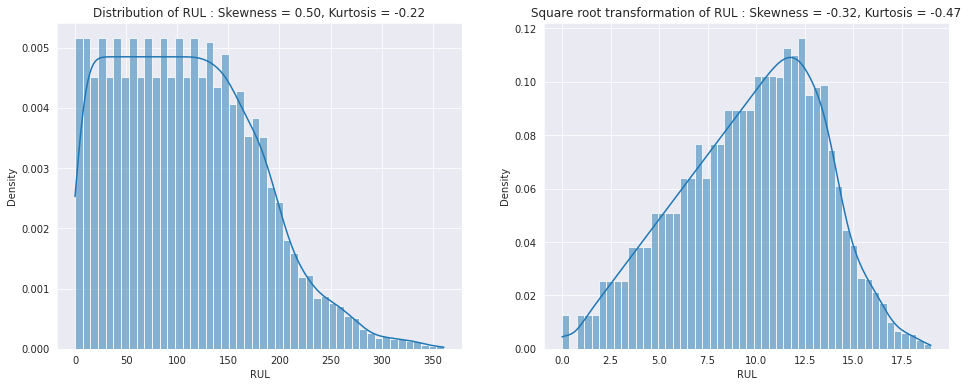

In [189]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
sns.histplot(data = train_df, x = 'RUL', stat = 'density', kde = True)
plt.title('Distribution of RUL : Skewness = %.2f, Kurtosis = %.2f' %(train_df['RUL'].skew(), train_df['RUL'].kurt()))

plt.subplot(1,2,2)
sns.histplot(x = np.sqrt(train_df['RUL']), stat = 'density', kde = True)
plt.title('Square root transformation of RUL : Skewness = %.2f, Kurtosis = %.2f' %(train_df['RUL'].apply(np.sqrt).skew(), 
                                                                                   train_df['RUL'].apply(np.sqrt).kurt()))
plt.show()

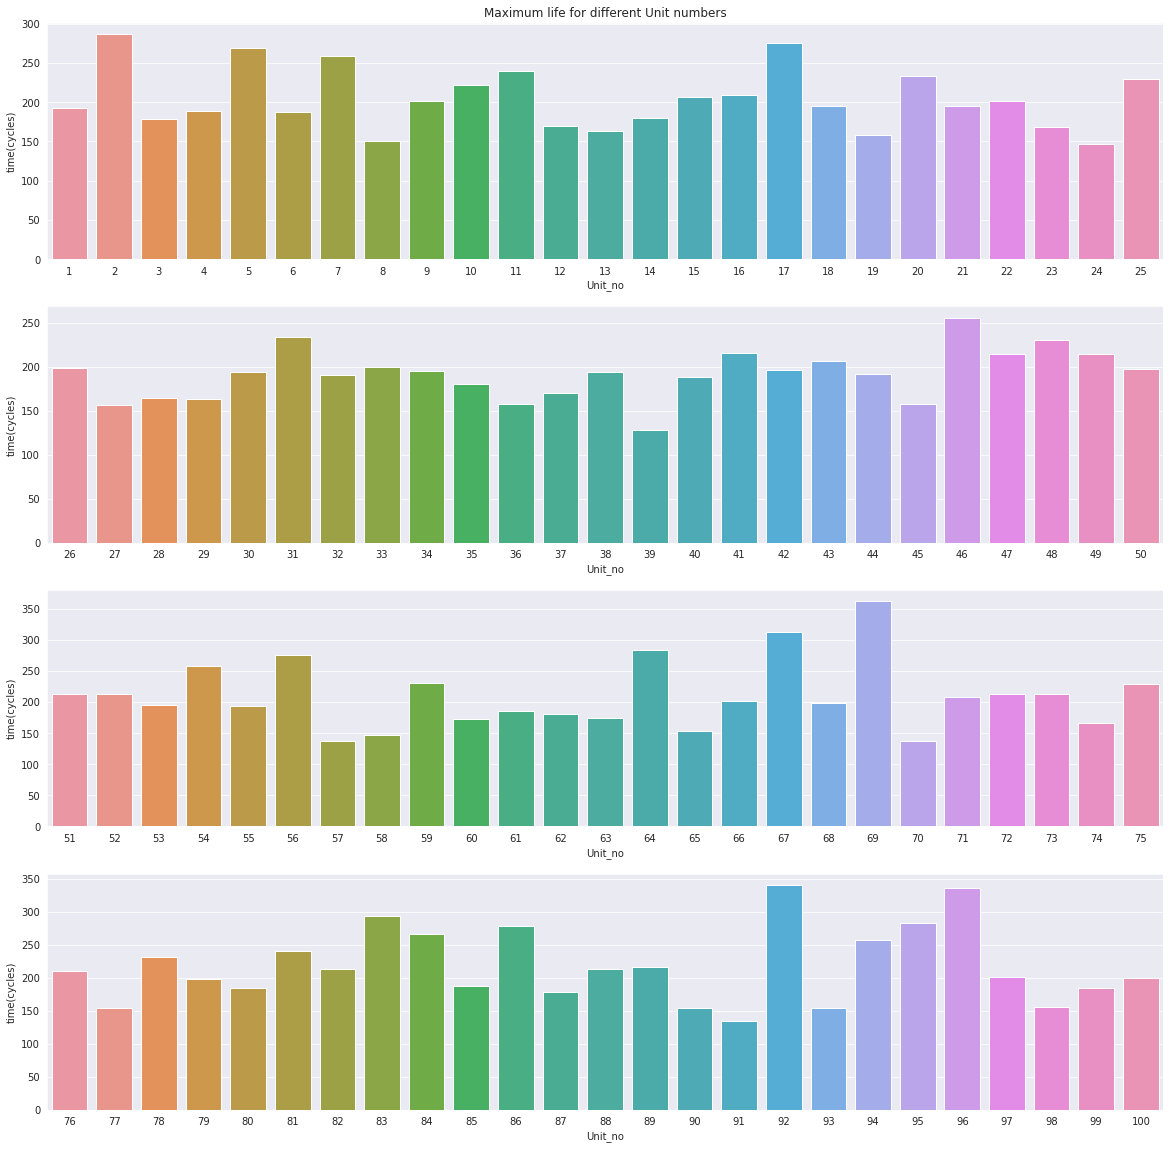

In [200]:
max_cycle = train_df.groupby('Unit_no')['time(cycles)'].max().reset_index()

plt.figure(figsize = (20,20))

plt.subplot(4,1,1)
sns.barplot(x = 'Unit_no', y = 'time(cycles)', data = max_cycle.query('Unit_no <= 25'))
plt.title('Maximum life for different Unit numbers')

plt.subplot(4,1,2)
sns.barplot(x = 'Unit_no', y = 'time(cycles)', data = max_cycle.query('Unit_no > 25 & Unit_no <=50'))

plt.subplot(4,1,3)
sns.barplot(x = 'Unit_no', y = 'time(cycles)', data = max_cycle.query('Unit_no > 50 & Unit_no <= 75'))

plt.subplot(4,1,4)
sns.barplot(x = 'Unit_no', y = 'time(cycles)', data = max_cycle.query('Unit_no > 75 & Unit_no <= 100'))

plt.show()

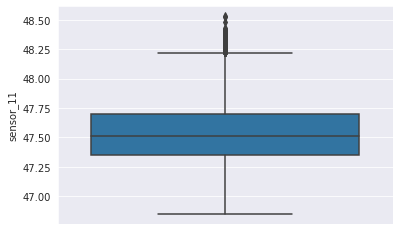

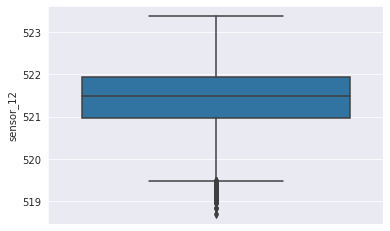

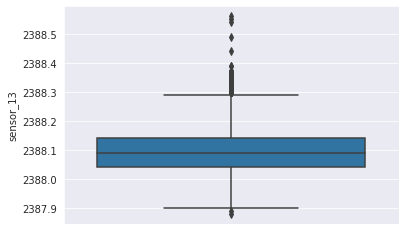

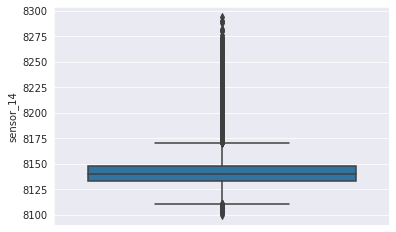

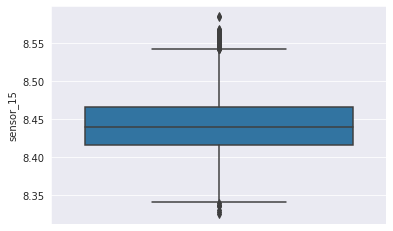

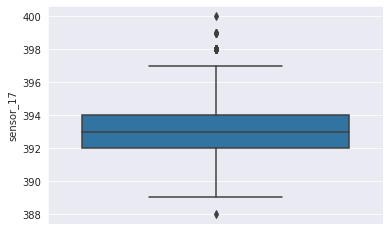

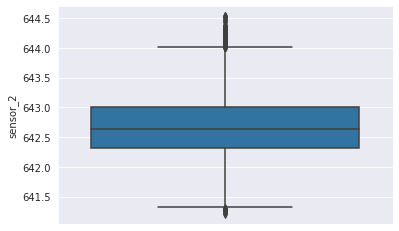

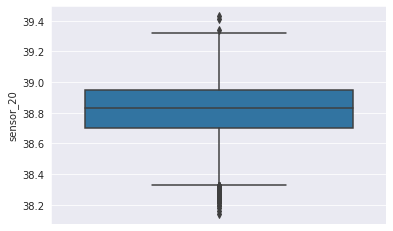

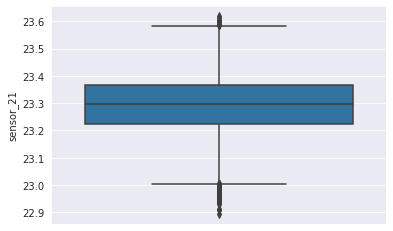

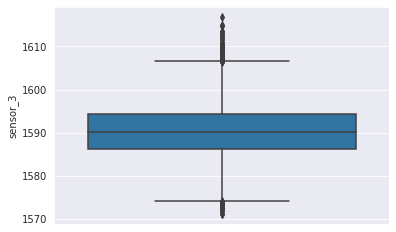

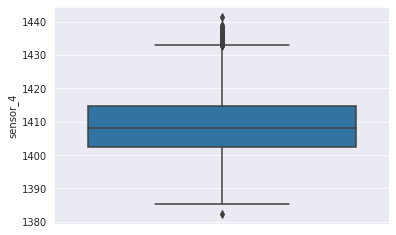

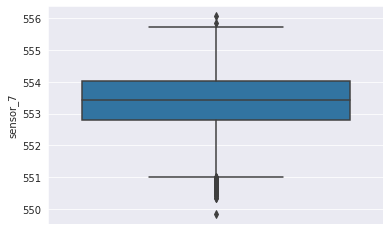

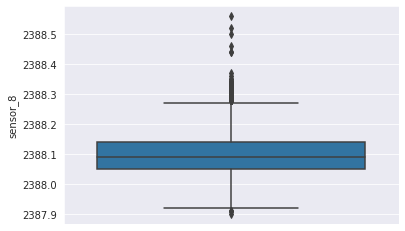

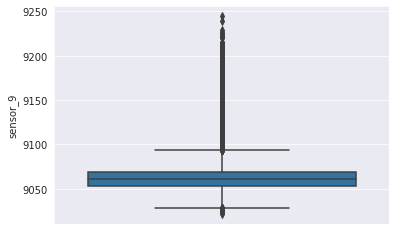

In [170]:
for col in train_df.columns.difference(index_cols + op_setting_cols + ['RUL']):
  sns.boxplot(y = col, data = train_df)
  plt.show()

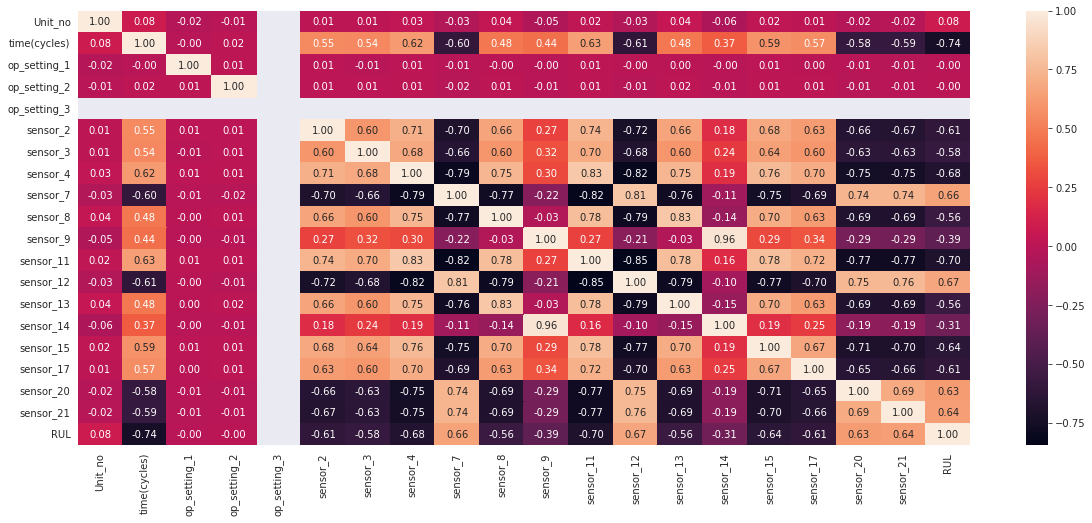

In [164]:
# Heatmap to view correlations
corr = train_df.corr()
plt.figure(figsize = (20,8))
sns.heatmap(corr, annot = True, fmt = '.2f')
plt.show()

In [88]:
train_df['Unit_no'].nunique()

100

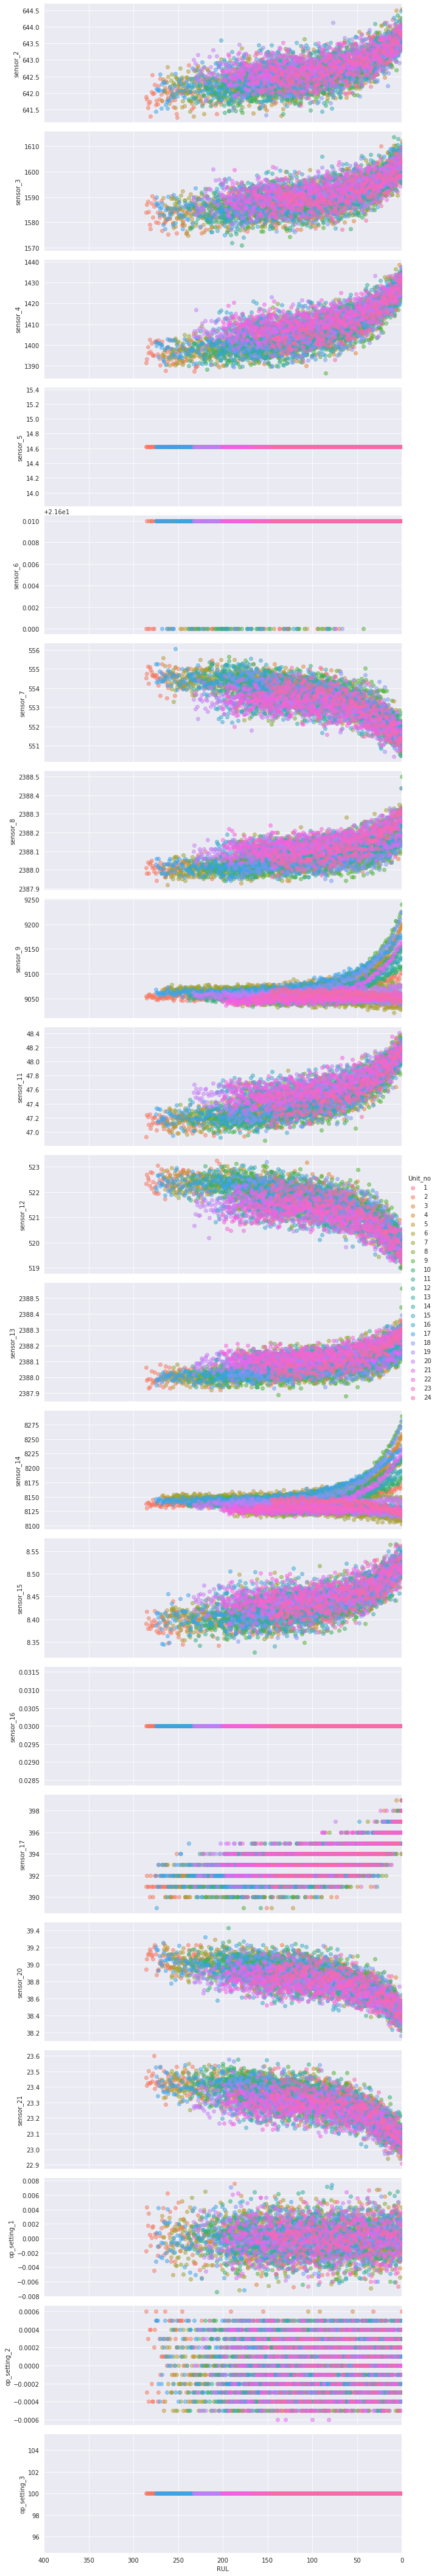

In [97]:
# use seaborn to visualize featuresto target (RUL)
xvars = 'RUL'
yvars = [col for col in sensor_cols if col in train_df.columns] + op_setting_cols
sns.set_style('darkgrid')
pair_grid = sns.PairGrid(data=train_df.query('Unit_no < 25'), x_vars=xvars, y_vars=yvars,
                          hue="Unit_no", height=3, aspect=3)
pair_grid = pair_grid.map(plt.scatter, alpha=0.5)
pair_grid = pair_grid.set(xlim=(400,0))
pair_grid = pair_grid.add_legend()

There is no variation w.r.t. op_setting_3. Let us explore the effect of op_setting 1 & 2 on sensor readings

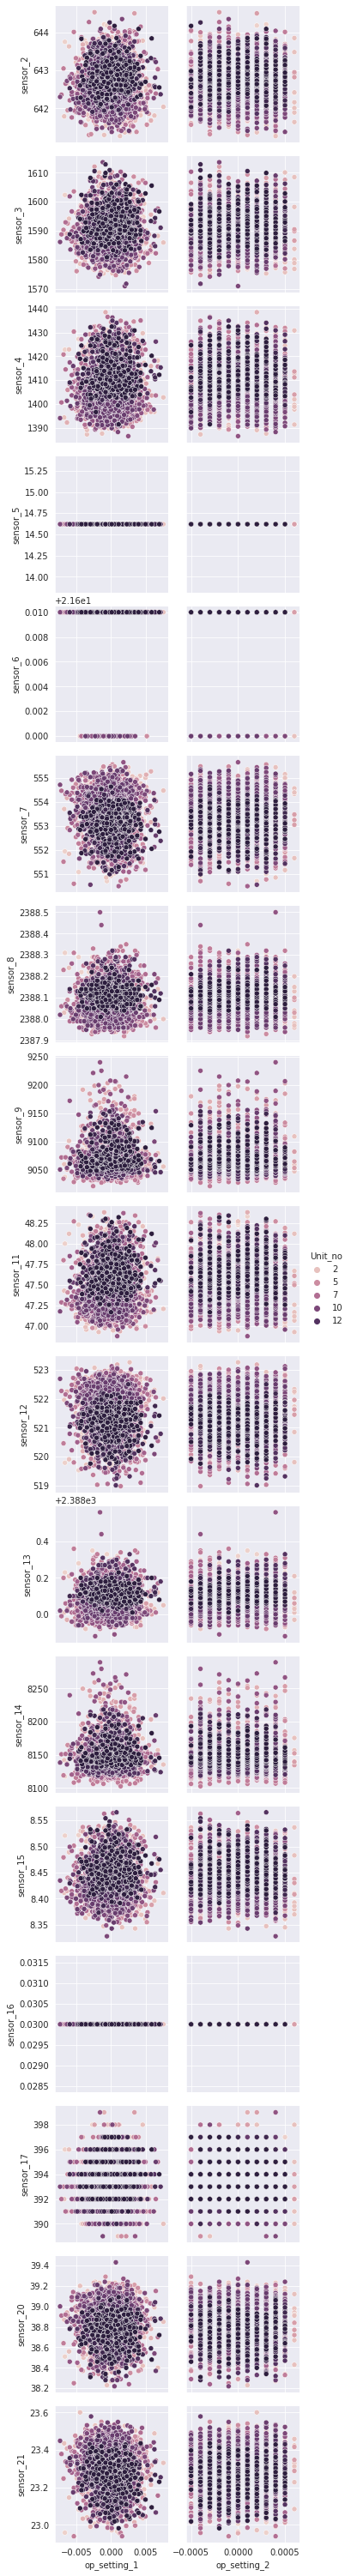

In [102]:
xvars = ['op_setting_1', 'op_setting_2']
yvars = [col for col in sensor_cols if col in train_df.columns] 
sns.pairplot(data = train_df.query('Unit_no < 25'), 
             x_vars = xvars, y_vars = yvars,
             hue = 'Unit_no', aspect = 1)
plt.show()

Removing the follwing column

weakly correlated with the RUL:    Unit_no, op_setting_1, op_setting_2, op_setting_3

strongly correlated features : sensor_9 and sensor_14 (removing sensor_14) 

In [202]:
train_df.drop(columns = ['Unit_no', 'time(cycles)','op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_14'], axis = 1, inplace = True)

In [205]:
train_df.columns

Index(['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17',
       'sensor_20', 'sensor_21', 'RUL'],
      dtype='object')

In [206]:
# Separating the predictors and response varaible
X_train = train_df.drop(columns = 'RUL', axis = 1).to_numpy()
y_train = train_df['RUL'].to_numpy()

In [207]:
# Feature selection with Random forest regressor
RF = RandomForestRegressor(n_estimators=200, max_depth = 15)
RF.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200)

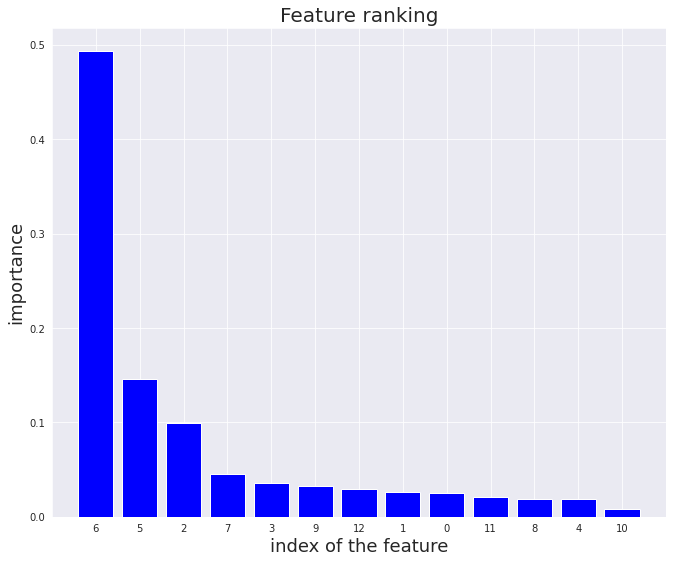

In [211]:
imp_features = RF.feature_importances_
idx = np.argsort(imp_features)[::-1]
feature_names = train_df.columns.difference(['RUL']) 

f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X_train.shape[1]), imp_features[idx], color="b", align="center")
plt.xticks(range(X_train.shape[1]), idx) #feature_names, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()